In [1]:

!pip install shap --quiet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import json
import os

In [2]:

np.random.seed(42)
N = 2000
coke_pct = np.random.uniform(15, 30, N)
hot_blast_temp = np.random.uniform(900, 1300, N)
oxygen_enrichment = np.random.uniform(20, 40, N)
ore_grade = np.random.uniform(55, 67, N)
throughput = np.random.uniform(50, 350, N)
scrap_ratio = np.random.uniform(0, 30, N)
flux_ratio = np.random.uniform(1, 5, N)

a = 40.0; b = 150.0; c = 25.0; d = 20.0; e = 0.5
noise = np.random.normal(0, 50, N)

co2_per_ton = (a * coke_pct) + (b * (1 - (ore_grade - 50)/50)) \
              + (c * (1 - scrap_ratio/100)) + (d * ((1300 - hot_blast_temp)/100)) \
              + e * (coke_pct * (1 - scrap_ratio/100)) + noise
co2_per_ton = np.clip(co2_per_ton, 200, None)

df = pd.DataFrame({
    "coke_pct": coke_pct,
    "hot_blast_temp": hot_blast_temp,
    "oxygen_enrichment": oxygen_enrichment,
    "ore_grade": ore_grade,
    "throughput": throughput,
    "scrap_ratio": scrap_ratio,
    "flux_ratio": flux_ratio,
    "co2_per_ton": co2_per_ton
})
df.to_csv("dataset.csv", index=False)
df.head()

,coke_pct,hot_blast_temp,oxygen_enrichment,ore_grade,throughput,scrap_ratio,flux_ratio,co2_per_ton
0,20.618102,1004.682273,31.439918,62.779083,266.080377,11.209225,3.617225,1017.472884
1,29.260715,998.791520,36.108647,57.068636,256.184901,9.987363,1.320130,1503.696344
2,25.979909,1262.501832,35.203219,65.468735,78.726260,5.284617,1.969319,1258.489296
3,23.979877,999.818480,23.077998,62.357395,326.771721,18.218000,4.094717,1078.790095
4,17.340280,1008.779890,22.984989,56.886447,220.541661,14.298725,3.114743,929.409021


Results: {'LinearRegression': {'rmse': 47.35722736293249, 'mae': 37.476714059035835, 'r2': 0.9362074042137881}, 'RandomForest': {'rmse': 49.60861817029939, 'mae': 39.261095302291636, 'r2': 0.9299977500104748}}


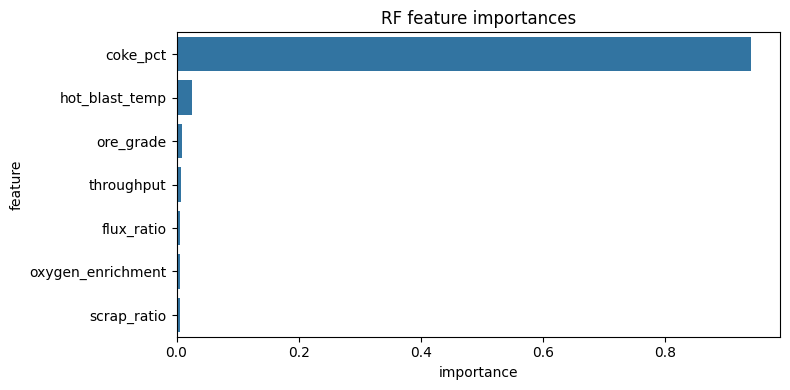

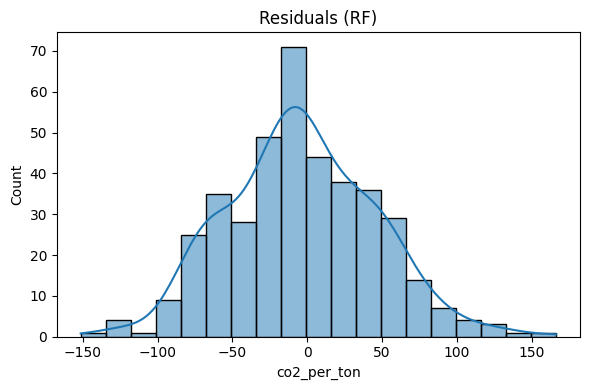

In [3]:
df = pd.read_csv("dataset.csv")
features = ["coke_pct","hot_blast_temp","oxygen_enrichment","ore_grade","throughput","scrap_ratio","flux_ratio"]
X = df[features]
y = df["co2_per_ton"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Save models
joblib.dump(lr, "linear_model.joblib")
joblib.dump(rf, "rf_model.joblib")

def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"rmse": float(rmse), "mae": float(mae), "r2": float(r2)}

results = {
    "LinearRegression": metrics(y_test, y_pred_lr),
    "RandomForest": metrics(y_test, y_pred_rf)
}
print("Results:", results)

# Save results
pd.DataFrame([
    {"model":"LinearRegression", **results["LinearRegression"]},
    {"model":"RandomForest", **results["RandomForest"]}
]).to_excel("model_results.xlsx", index=False)

# Quick plots
fi = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending=False)
plt.figure(figsize=(8,4)); sns.barplot(x="importance", y="feature", data=fi); plt.title("RF feature importances"); plt.tight_layout(); plt.savefig("feature_importance.png", dpi=150)
plt.figure(figsize=(6,4)); sns.histplot(y_test - y_pred_rf, kde=True); plt.title("Residuals (RF)"); plt.tight_layout(); plt.savefig("residuals_rf.png", dpi=150)

In [4]:
from itertools import combinations
records = []
all_feats = features.copy()

for k in range(1, len(all_feats)+1):
    for combo in combinations(all_feats, k):
        Xc = df[list(combo)]
        Xt, Xv, yt, yv = train_test_split(Xc, y, test_size=0.2, random_state=42)
        model = RandomForestRegressor(n_estimators=150, max_depth=8, random_state=42, n_jobs=-1)
        model.fit(Xt, yt)
        pred = model.predict(Xv)
        rmse = np.sqrt(mean_squared_error(yv, pred))
        records.append({"features": ",".join(combo), "n_features": len(combo), "rmse": float(rmse)})
ab_df = pd.DataFrame(records).sort_values("rmse")
ab_df.to_excel("ablation_results_full.xlsx", index=False)
ab_df.head(20)

,features,n_features,rmse
126,"coke_pct,hot_blast_temp,oxygen_enrichment,ore_...",7,49.578267
123,"coke_pct,hot_blast_temp,ore_grade,throughput,s...",6,49.642905
104,"coke_pct,hot_blast_temp,ore_grade,throughput,s...",5,49.761170
120,"coke_pct,hot_blast_temp,oxygen_enrichment,ore_...",6,49.865662
119,"coke_pct,hot_blast_temp,oxygen_enrichment,ore_...",6,49.924381
121,"coke_pct,hot_blast_temp,oxygen_enrichment,ore_...",6,49.957575
105,"coke_pct,hot_blast_temp,ore_grade,throughput,f...",5,49.964550
106,"coke_pct,hot_blast_temp,ore_grade,scrap_ratio,...",5,50.011886
70,"coke_pct,hot_blast_temp,throughput,scrap_ratio",4,50.026021
122,"coke_pct,hot_blast_temp,oxygen_enrichment,thro...",6,50.045301


/tmp/ipython-input-3966234062.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf, X_test, show=False)
/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
/tmp/ipython-input-3966234062.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_lr, X_test, show=False)


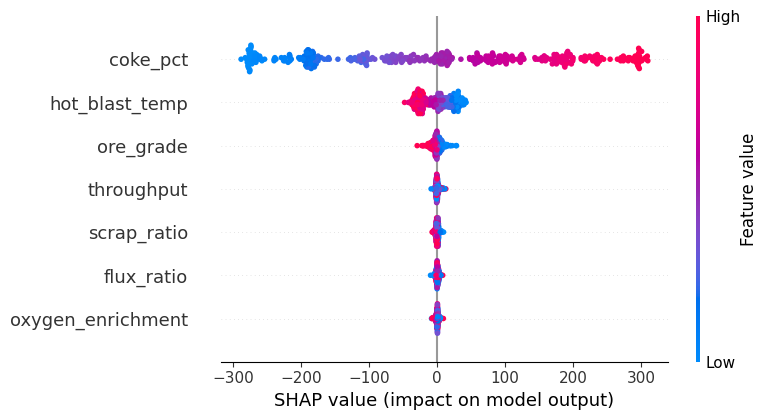

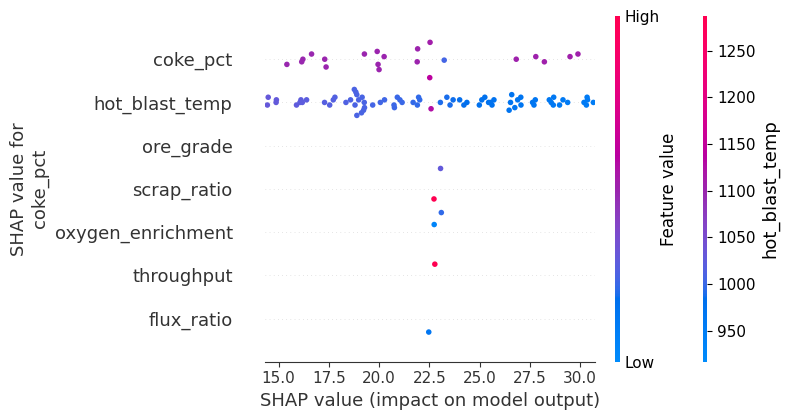

In [5]:
# Use RF (trained earlier)
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test)  # array

# Summary plot (global)
shap.summary_plot(shap_values_rf, X_test, show=False)
plt.savefig("shap_summary_rf.png", dpi=150, bbox_inches='tight')

# Dependence plot for top feature
top_feat = fi.feature.values[0]
shap.dependence_plot(top_feat, shap_values_rf, X_test, show=False)
plt.savefig("shap_dependence_"+top_feat+".png", dpi=150, bbox_inches='tight')

# For linear model
explainer_lr = shap.LinearExplainer(lr, X_train, feature_perturbation="interventional")
shap_values_lr = explainer_lr.shap_values(X_test)
shap.summary_plot(shap_values_lr, X_test, show=False)
plt.savefig("shap_summary_lr.png", dpi=150, bbox_inches='tight')

In [6]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('initial_results.pdf') as pdf:
    # Page 1: Title + short text
    plt.figure(figsize=(8.27, 11.69))  # A4
    plt.axis('off')
    txt = [
        "Initial Baseline Results — Refined RQ1",
        "",
        "Dataset: dataset.csv (2000 rows). Features: " + ", ".join(features),
        "",
        "Models trained: Linear Regression, Random Forest (RF).",
        "",
        "Key results (test set):",
        f"Linear Regression -> RMSE: {results['LinearRegression']['rmse']:.2f}, MAE: {results['LinearRegression']['mae']:.2f}, R2: {results['LinearRegression']['r2']:.3f}",
        f"Random Forest -> RMSE: {results['RandomForest']['rmse']:.2f}, MAE: {results['RandomForest']['mae']:.2f}, R2: {results['RandomForest']['r2']:.3f}",
        "",
        "Preliminary interpretation: Linear Regression outperformed Random Forest, indicating near-linear relationships between inputs and CO2 in the modeled ranges. Next: ablation, SHAP, and scenario tests."
    ]
    plt.text(0.01, 0.99, "\n".join(txt), va='top', fontsize=11)
    pdf.savefig(); plt.close()
    # Page 2: feature importance
    fig = plt.figure(figsize=(8.27, 11.69))
    img = plt.imread('feature_importance.png')
    plt.imshow(img); plt.axis('off')
    pdf.savefig(); plt.close()
    # Page 3: SHAP summary
    fig = plt.figure(figsize=(8.27, 11.69))
    img2 = plt.imread('shap_summary_rf.png')
    plt.imshow(img2); plt.axis('off')
    pdf.savefig(); plt.close()
print("Saved initial_results.pdf")

Saved initial_results.pdf


In [7]:
# PHASE 1: Identify minimal feature sets and retrain them
import pandas as pd, numpy as np, joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load full ablation file (from previous run)
ab_df = pd.read_excel("ablation_results_full.xlsx")  # produced earlier
# Sort by rmse and keep top combos with small n_features
top_small = ab_df[ab_df['n_features']<=4].sort_values('rmse').head(20)
top_small.to_excel("ablation_top_small_candidates.xlsx", index=False)

# Choose two candidate minimal sets automatically: best with n_features<=3 and best with n_features==4
cand1 = top_small[top_small['n_features']<=3].iloc[0]['features']
cand2 = top_small[top_small['n_features']==4].iloc[0]['features'] if not top_small[top_small['n_features']==4].empty else top_small.iloc[0]['features']

print("Candidate 1 (<=3 features):", cand1)
print("Candidate 2 (4 features):", cand2)

# Helper to evaluate sets on Linear Regression and RF with consistent split
df = pd.read_csv("dataset.csv")
y = df['co2_per_ton']

def eval_set(feature_list):
    X = df[feature_list]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lr = LinearRegression().fit(X_train, y_train)
    rf = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1).fit(X_train, y_train)
    preds_lr = lr.predict(X_test); preds_rf = rf.predict(X_test)
    def metrics(y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred)); mae = mean_absolute_error(y_true, y_pred); r2 = r2_score(y_true, y_pred)
        return {"rmse":rmse,"mae":mae,"r2":r2}
    return {"features":feature_list, "LR":metrics(y_test,preds_lr), "RF":metrics(y_test,preds_rf)}

# parse features
f1 = cand1.split(',')
f2 = cand2.split(',')

res1 = eval_set([f.strip() for f in f1])
res2 = eval_set([f.strip() for f in f2])

pd.DataFrame([{"choice":"minset_A","features":res1['features'],**{"LR_rmse":res1['LR']['rmse'],"RF_rmse":res1['RF']['rmse']}},
              {"choice":"minset_B","features":res2['features'],**{"LR_rmse":res2['LR']['rmse'],"RF_rmse":res2['RF']['rmse']}}])\
.to_excel("ablation_minsets_results.xlsx", index=False)

print("Saved ablation_minsets_results.xlsx")

Candidate 1 (<=3 features): coke_pct,hot_blast_temp,throughput
Candidate 2 (4 features): coke_pct,hot_blast_temp,throughput,scrap_ratio
Saved ablation_minsets_results.xlsx


Saved scenario_results.xlsx and plots.


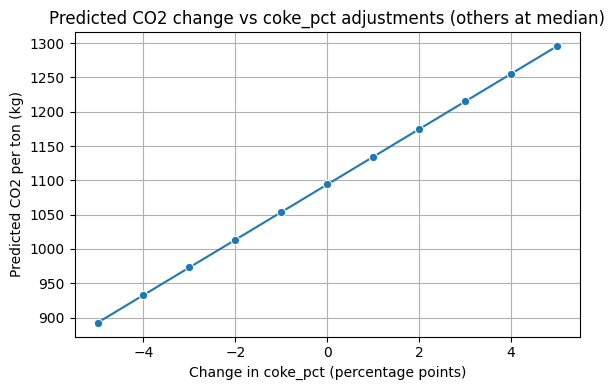

In [8]:
# PHASE 2: Scenario testing (replace minset_final)
import pandas as pd, numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt, seaborn as sns


minset_final = ["coke_pct","hot_blast_temp","throughput"]

# Load data and train LR on minimal set
df = pd.read_csv("dataset.csv")
X = df[minset_final]; y = df['co2_per_ton']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LinearRegression().fit(X_train, y_train)

# Scenario construction: vary coke_pct -5%..+5% in 1% steps around median; hold others at medians
medians = X.median().to_dict()
scenarios = []
for delta in np.arange(-5, 6, 1):  # -5 to +5
    s = medians.copy()
    if "coke_pct" in s:
        s["coke_pct"] = max(5, s["coke_pct"] + delta)  # prevent negative
    scenarios.append((f"coke_delta_{delta}", s.copy()))

# Convert scenarios to DataFrame
rows = []
for name, s in scenarios:
    rows.append(s)
sc_df = pd.DataFrame(rows)

# Predict using LR
preds = lr.predict(sc_df)
sc_df['pred_co2'] = preds
sc_df['coke_delta'] = np.arange(-5,6,1)
sc_df.to_excel("scenario_results.xlsx", index=False)

# Plot CO2 vs coke_delta
plt.figure(figsize=(6,4))
sns.lineplot(x='coke_delta', y='pred_co2', data=sc_df, marker="o")
plt.xlabel("Change in coke_pct (percentage points)")
plt.ylabel("Predicted CO2 per ton (kg)")
plt.title("Predicted CO2 change vs coke_pct adjustments (others at median)")
plt.grid(True)
plt.tight_layout()
plt.savefig("scenario_plot_coke_vs_co2.png", dpi=150)

# If oxygen is in minset_final, do 2D heatmap for coke_pct and oxygen_enrichment
if "oxygen_enrichment" in minset_final:
    # build grid
    c_range = np.arange(medians["coke_pct"]-5, medians["coke_pct"]+6, 1)
    o_range = np.arange(max(10, medians["oxygen_enrichment"]-3), medians["oxygen_enrichment"]+4, 1)
    grid = []
    for c in c_range:
        for o in o_range:
            s = medians.copy()
            s["coke_pct"] = c; s["oxygen_enrichment"] = o
            grid.append(s)
    grid_df = pd.DataFrame(grid)
    grid_df['pred_co2'] = lr.predict(grid_df)
    pivot = grid_df.pivot_table(index='coke_pct', columns='oxygen_enrichment', values='pred_co2')
    plt.figure(figsize=(6,5)); sns.heatmap(pivot, cmap='viridis'); plt.title("CO2 heatmap (coke_pct vs oxygen_enrichment)"); plt.tight_layout()
    plt.savefig("scenario_heatmap_coke_oxygen.png", dpi=150)

print("Saved scenario_results.xlsx and plots.")

In [9]:
# PHASE 3: Robustness checks & coefficient CI
import pandas as pd, numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

seeds = [42, 7, 1234]
results = []
coeffs = []

for s in seeds:
    np.random.seed(s)
    # regenerate dataset with same formula (paste formula used earlier)
    N=2000
    coke_pct = np.random.uniform(15,30,N)
    hot_blast_temp = np.random.uniform(900,1300,N)
    oxygen_enrichment = np.random.uniform(20,40,N)
    ore_grade = np.random.uniform(55,67,N)
    throughput = np.random.uniform(50,350,N)
    scrap_ratio = np.random.uniform(0,30,N)
    flux_ratio = np.random.uniform(1,5,N)
    a,b,c,d,e = 40.0,150.0,25.0,20.0,0.5
    noise = np.random.normal(0,50,N)
    co2_per_ton = (a*coke_pct)+(b * (1 - (ore_grade - 50)/50)) + (c * (1 - scrap_ratio/100)) + (d * ((1300 - hot_blast_temp)/100)) + e * (coke_pct * (1 - scrap_ratio/100)) + noise
    co2_per_ton = np.clip(co2_per_ton, 200, None)
    df_s = pd.DataFrame({"coke_pct":coke_pct,"hot_blast_temp":hot_blast_temp,"oxygen_enrichment":oxygen_enrichment,"ore_grade":ore_grade,"throughput":throughput,"scrap_ratio":scrap_ratio,"flux_ratio":flux_ratio,"co2_per_ton":co2_per_ton})

    # train/test
    X = df_s[minset_final]; y = df_s['co2_per_ton']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lr = LinearRegression().fit(X_train, y_train)
    pred = lr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    results.append({"seed":s, "rmse":rmse})

    # OLS for CI (statsmodels)
    X_ols = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_ols).fit()
    ci = model.conf_int(alpha=0.05)
    coeff = pd.DataFrame({"param":model.params.index, "coef":model.params.values})
    coeff = coeff.merge(pd.DataFrame(ci, columns=['ci_low','ci_high']), left_on='param', right_index=True)
    coeff['seed']=s
    coeffs.append(coeff)

pd.DataFrame(results).to_excel("robustness_results.xlsx", index=False)
pd.concat(coeffs).to_excel("coeff_ci.xlsx", index=False)
print("Saved robustness_results.xlsx and coeff_ci.xlsx")

Saved robustness_results.xlsx and coeff_ci.xlsx


In [10]:
# PHASE 4: SHAP plots compiling into PDF
import shap, pandas as pd, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.backends.backend_pdf as bpdf

df = pd.read_csv("dataset.csv")
X = df[minset_final]; y = df['co2_per_ton']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# retrain final RF for SHAP (even if LR is best, RF SHAP is useful)
rf = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1).fit(X_train,y_train)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# summary plot
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("shap_summary_final.png", dpi=150, bbox_inches='tight')
plt.close()

# local explanations: choose highest predicted and lowest predicted samples
preds = rf.predict(X_test)
high_idx = preds.argmax(); low_idx = preds.argmin()
shap.force_plot(explainer.expected_value, shap_values[high_idx,:], X_test.iloc[high_idx,:], matplotlib=True, show=False)
plt.savefig("shap_force_high.png", dpi=150, bbox_inches='tight'); plt.close()
shap.force_plot(explainer.expected_value, shap_values[low_idx,:], X_test.iloc[low_idx,:], matplotlib=True, show=False)
plt.savefig("shap_force_low.png", dpi=150, bbox_inches='tight'); plt.close()

# Combine into PDF
with bpdf.PdfPages("shap_plots.pdf") as pdf:
    fig = plt.figure(figsize=(8.27,11.69)); img = plt.imread("shap_summary_final.png"); plt.imshow(img); plt.axis('off'); pdf.savefig(); plt.close()
    fig = plt.figure(figsize=(8.27,11.69)); img = plt.imread("shap_force_high.png"); plt.imshow(img); plt.axis('off'); pdf.savefig(); plt.close()
    fig = plt.figure(figsize=(8.27,11.69)); img = plt.imread("shap_force_low.png"); plt.imshow(img); plt.axis('off'); pdf.savefig(); plt.close()
print("Saved shap_plots.pdf")

/tmp/ipython-input-551002289.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, show=False)


Saved shap_plots.pdf
